In [1]:
# coding: utf-8

import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
import glob
import json

IMG_SIZE = (180, 320)
drop_ratio=0.2

In [ ]:
class VideoAnalyze():
    def __init__(self,video_name):
        # 特徴量抽出
        # A-KAZE検出器の生成
#         self.detector = cv2.AKAZE_create()
#         self.detector = cv2.KAZE_create()
#         self.detector = cv2.ORB_create()
        # Brute-Force Matcher生成
        self.bf=cv2.BFMatcher(cv2.NORM_L1,crossCheck=False)
        self.cascade = cv2.CascadeClassifier('cascade.xml') #分類器の指定
        self.video_name=video_name

    def show(self, match):
        img1=match['img1']
        img2=match['img2']
        plt.figure(figsize=(16,12))
        # 左
        plt.subplot(2,2,1)
        plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
        # 右
        plt.subplot(2,2,2)
        plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
        plt.show()
        

    def show_matching(self, match):
        matched=match['matched']
        kp1=match['kp1']
        kp2=match['kp2']
        img1=match['img1']
        img2=match['img2']
        # 対応する特徴点同士を描画
        img = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matched, None, flags=2)
#     img = cv2.drawMatches(img1, kp1, img2, kp2, matched, None, flags=2)
        plt.figure(figsize=(16,12))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()

    def compare_frame(self, frame, frame_path):
        # 特徴量の検出と特徴量ベクトルの計算
        self.top_match={}
        gray_tmp=frame.copy()
#         gray_tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)
        gray_tmp = cv2.resize(gray_tmp, IMG_SIZE)
        gray_tmp=gray_tmp[10:320, 0:180]
#         __, target_des = self.detector.detectAndCompute(gray_tmp, None)
        y=310
        x=180
        target_hist1 = cv2.calcHist([gray_tmp[0:int(y/2), 0:int(x/2)]], [0], None, [256], [0, 256])
        target_hist2 = cv2.calcHist([gray_tmp[0:int(y/2), int(x/2):x]], [0], None, [256], [0, 256])
        target_hist3 = cv2.calcHist([gray_tmp[int(y/2):y, 0:int(x/2)]], [0], None, [256], [0, 256])
        target_hist4 = cv2.calcHist([gray_tmp[int(y/2):y, int(x/2):x]], [0], None, [256], [0, 256])
        for path in glob.glob('./base_img/*.png'):
            try:
    #             matches = bf.match(target_des, d_dict[path]['des'])
    #             dist = [m.distance for m in matches]
    #             matched = [m for m in matches]
    #             matched = sorted(matches, key=lambda x:x.distance)

#                 matches = self.bf.knnMatch(target_des, self.d_dict[path]['des'], k=2)
#                 dist = []
#                 matched=[]
#                 for m, n in matches:
#                     if m.distance < drop_ratio * n.distance:
#                         matched.append([m])
#                         dist.append(m.distance)

#                 ret = sum(dist) / len(dist)
                ret=[]
                ret.append(cv2.compareHist(target_hist1, self.d_dict[path]['hist1'], 0))
                ret.append(cv2.compareHist(target_hist2, self.d_dict[path]['hist2'], 0))
                ret.append(cv2.compareHist(target_hist3, self.d_dict[path]['hist3'], 0))
                ret.append(cv2.compareHist(target_hist4, self.d_dict[path]['hist4'], 0))
                print("{0} : {1} : {2}".format(path, frame_path,sum(ret)))
                if not self.top_match or self.top_match['ret'] < sum(ret):
                    self.top_match['ret']=sum(ret)
                    self.top_match['path']=path
                    self.top_match['ts']={'img1':self.d_dict[path]['img'],'img2':gray_tmp}
#                     self.top_match['ts']={'matched':matched, 'img1':self.d_dict[path]['img'], \
#                                           'kp1':self.d_dict[path]['kp'],'img2':gray_tmp, 'kp2':__,} 
            except cv2.error:
                ret = 100000

        print(self.top_match['path'], self.top_match['ret'])
#         self.show_matching(self.top_match['ts'])
        self.show(self.top_match['ts'])

    def create_base_sienario(self, frame, detect, senario_dict, i):
        tmp=frame.copy()
        for (x, y, w, h) in detect:
            # タップライン
            height, width = tmp.shape[:2]
            tap_line=tmp[y:y+h, 0:width]
            tap_line_name='./s_img/tap_line_{0}.jpg'.format(i)
            cv2.imwrite(tap_line_name, tap_line)
            senario_dict[i]={}
            senario_dict[i]['line']={}
            senario_dict[i]['line']['base']=self.top_match['path']
            senario_dict[i]['line']['match']=tap_line_name
            senario_dict[i]['line']['is_parent']=True
            senario_dict[i]['line']['scale']=1

            # タップ位置
            tap_img=tmp[y:y+h, x:x+w]
            tap_name='./s_img/tap_{0}.jpg'.format(i)
            cv2.imwrite(tap_name, tap_img)
            senario_dict[i]['tap']={}
            senario_dict[i]['tap']['base']=None
            senario_dict[i]['tap']['match']=tap_name
            senario_dict[i]['tap']['scale']=1
            i+=1
        return i

    def main(self):
        senario_dict={}
        self.d_dict={}
        for img_path in glob.glob('./base_img/*.png'):
            gray_img = cv2.imread(img_path)
#             gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            gray_img = cv2.resize(gray_img, IMG_SIZE)
            gray_img=gray_img[10:320, 0:180]
#             kp, des = self.detector.detectAndCompute(gray_img, None)          
            self.d_dict[img_path]={}
#             self.d_dict[img_path]['des']=des
#             self.d_dict[img_path]['kp']=kp
            self.d_dict[img_path]['img']=gray_img
            y=310
            x=180
#             self.d_dict[img_path]['hist'] = cv2.calcHist([gray_img], [0], None, [256], [0, 256])
            self.d_dict[img_path]['hist1'] = cv2.calcHist([gray_img[0:int(y/2), 0:int(x/2)]], [0], None, [256], [0, 256])
            self.d_dict[img_path]['hist2'] = cv2.calcHist([gray_img[0:int(y/2), int(x/2):x]], [0], None, [256], [0, 256])
            self.d_dict[img_path]['hist3'] = cv2.calcHist([gray_img[int(y/2):y, 0:int(x/2)]], [0], None, [256], [0, 256])
            self.d_dict[img_path]['hist4'] = cv2.calcHist([gray_img[int(y/2):y, int(x/2):x]], [0], None, [256], [0, 256])
        i=0
        cap = cv2.VideoCapture(self.video_name)
        
        #print("{0}: is Open {1}".format(self.video_name, cap.isOpened()))
#         prev_detect=np.array([[-1,-1,-1,-1]])
#         while(cap.isOpened()):
        for frame_path in glob.glob('./cat_img/*.png'):
#             ret, frame = cap.read()
            frame = cv2.imread(frame_path)
            if frame is None:
                break
            #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # detectMultiScale(Mat image, MatOfRect objects, double scaleFactor, int minNeighbors, int flag, Size minSize, Size maxSize)
            detect = self.cascade.detectMultiScale(frame, 1.1, 3) #物体の検出
#             print (detect,prev_detect)
            if type(detect) is tuple or (detect == prev_detect).all():
                prev_detect= np.array([[-1,-1,-1,-1]]) if type(detect) is tuple else detect
                continue
            print(detect)
            self.compare_frame(frame, frame_path)
            i=self.create_base_sienario(frame, detect, senario_dict, i)
            prev_detect=detect
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        # print(senario_dict)
#         cap.release()
        return senario_dict

[[654 647 181 181]]
./base_img/Screenshot_20170620-194333.png : ./cat_img/9004.png : 0.27487899306487806
./base_img/Screenshot_20170620-194300.png : ./cat_img/9004.png : 1.5857502708654199
./base_img/Screenshot_20170620-194357.png : ./cat_img/9004.png : 2.278364880972036
./base_img/Screenshot_20170620-194337.png : ./cat_img/9004.png : 0.27299717568212556
./base_img/Screenshot_20170620-194415.png : ./cat_img/9004.png : 0.5594769764926076
./base_img/Screenshot_20170620-194222.png : ./cat_img/9004.png : 0.26889310416120127
./base_img/Screenshot_20170620-194353.png : ./cat_img/9004.png : 1.5870787056130353
./base_img/Screenshot_20170620-194311.png : ./cat_img/9004.png : 1.9338074168444754
./base_img/Screenshot_20170620-194306.png : ./cat_img/9004.png : 2.2770364462244204
./base_img/Screenshot_20170620-194215.png : ./cat_img/9004.png : 0.2714812855630988
./base_img/Screenshot_20170620-194231.png : ./cat_img/9004.png : 0.2728158097514767
./base_img/Screenshot_20170620-194348.png : ./cat_img/

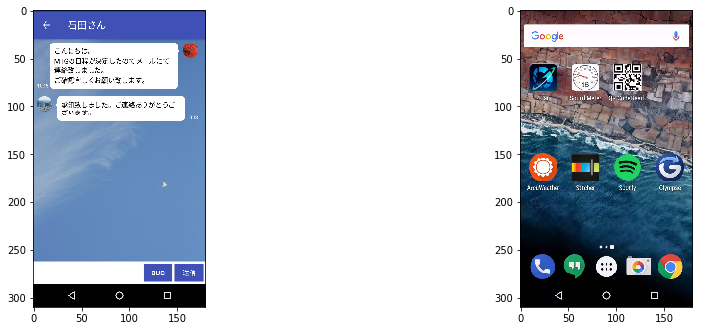

[[ 19 119 142 142]]
./base_img/Screenshot_20170620-194333.png : ./cat_img/0809.png : 0.06306180931667761
./base_img/Screenshot_20170620-194300.png : ./cat_img/0809.png : 0.26692098959320426
./base_img/Screenshot_20170620-194357.png : ./cat_img/0809.png : 0.18634859468822712
./base_img/Screenshot_20170620-194337.png : ./cat_img/0809.png : 0.06160386471621664
./base_img/Screenshot_20170620-194415.png : ./cat_img/0809.png : 0.14850210633174343
./base_img/Screenshot_20170620-194222.png : ./cat_img/0809.png : 0.0607528188997145
./base_img/Screenshot_20170620-194353.png : ./cat_img/0809.png : 0.2678113889841591
./base_img/Screenshot_20170620-194311.png : ./cat_img/0809.png : 0.17358269081388894
./base_img/Screenshot_20170620-194306.png : ./cat_img/0809.png : 0.1854581952972722
./base_img/Screenshot_20170620-194215.png : ./cat_img/0809.png : 0.060953910008632844
./base_img/Screenshot_20170620-194231.png : ./cat_img/0809.png : 0.06270033964531271
./base_img/Screenshot_20170620-194348.png : ./c

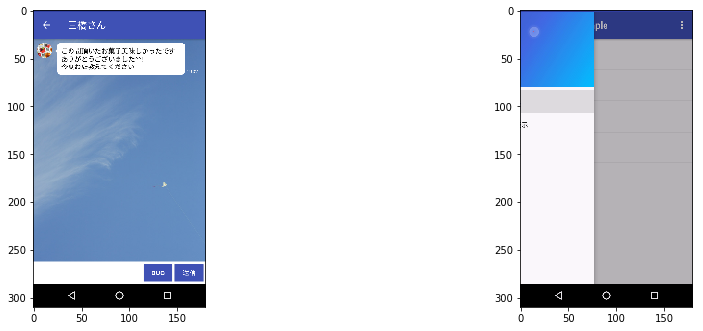

[[ 130 1022  150  150]]
./base_img/Screenshot_20170620-194333.png : ./cat_img/0905.png : 0.394526834760915
./base_img/Screenshot_20170620-194300.png : ./cat_img/0905.png : 3.8802726528268128
./base_img/Screenshot_20170620-194357.png : ./cat_img/0905.png : 3.85311264538055
./base_img/Screenshot_20170620-194337.png : ./cat_img/0905.png : 0.39530394373529487
./base_img/Screenshot_20170620-194415.png : ./cat_img/0905.png : 0.2463673575520919
./base_img/Screenshot_20170620-194222.png : ./cat_img/0905.png : 0.23376126859522328
./base_img/Screenshot_20170620-194353.png : ./cat_img/0905.png : 3.868822122310568
./base_img/Screenshot_20170620-194311.png : ./cat_img/0905.png : 3.9375681789532466
./base_img/Screenshot_20170620-194306.png : ./cat_img/0905.png : 3.8645631758967953
./base_img/Screenshot_20170620-194215.png : ./cat_img/0905.png : 0.40636658337472154
./base_img/Screenshot_20170620-194231.png : ./cat_img/0905.png : 0.3956406388953161
./base_img/Screenshot_20170620-194348.png : ./cat_img

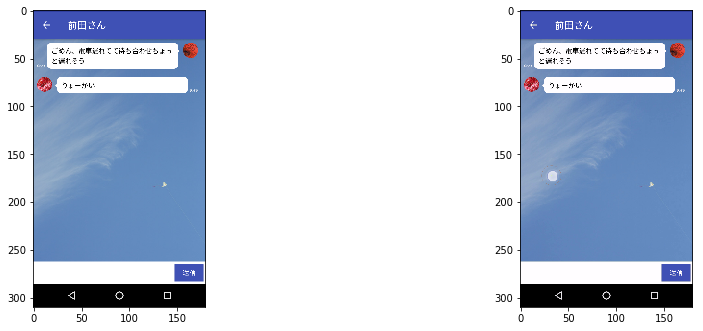

[[654 647 181 181]]
./base_img/Screenshot_20170620-194333.png : ./cat_img/9012.png : 0.27487899306487806
./base_img/Screenshot_20170620-194300.png : ./cat_img/9012.png : 1.5857502708654199
./base_img/Screenshot_20170620-194357.png : ./cat_img/9012.png : 2.278364880972036
./base_img/Screenshot_20170620-194337.png : ./cat_img/9012.png : 0.27299717568212556
./base_img/Screenshot_20170620-194415.png : ./cat_img/9012.png : 0.5594769764926076
./base_img/Screenshot_20170620-194222.png : ./cat_img/9012.png : 0.26889310416120127
./base_img/Screenshot_20170620-194353.png : ./cat_img/9012.png : 1.5870787056130353
./base_img/Screenshot_20170620-194311.png : ./cat_img/9012.png : 1.9338074168444754
./base_img/Screenshot_20170620-194306.png : ./cat_img/9012.png : 2.2770364462244204
./base_img/Screenshot_20170620-194215.png : ./cat_img/9012.png : 0.2714812855630988
./base_img/Screenshot_20170620-194231.png : ./cat_img/9012.png : 0.2728158097514767
./base_img/Screenshot_20170620-194348.png : ./cat_img/

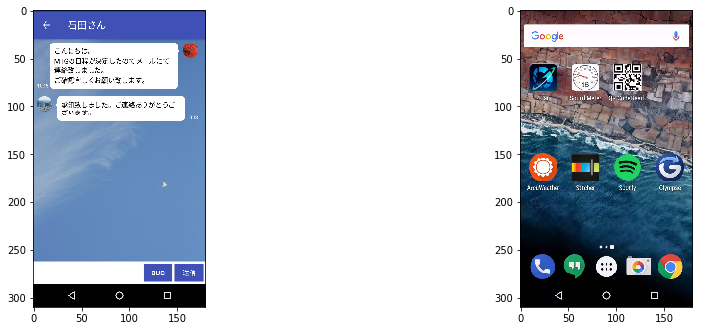

[[654 647 181 181]]
./base_img/Screenshot_20170620-194333.png : ./cat_img/9001.png : 0.27487899306487806
./base_img/Screenshot_20170620-194300.png : ./cat_img/9001.png : 1.5857502708654199
./base_img/Screenshot_20170620-194357.png : ./cat_img/9001.png : 2.278364880972036
./base_img/Screenshot_20170620-194337.png : ./cat_img/9001.png : 0.27299717568212556
./base_img/Screenshot_20170620-194415.png : ./cat_img/9001.png : 0.5594769764926076
./base_img/Screenshot_20170620-194222.png : ./cat_img/9001.png : 0.26889310416120127
./base_img/Screenshot_20170620-194353.png : ./cat_img/9001.png : 1.5870787056130353
./base_img/Screenshot_20170620-194311.png : ./cat_img/9001.png : 1.9338074168444754
./base_img/Screenshot_20170620-194306.png : ./cat_img/9001.png : 2.2770364462244204
./base_img/Screenshot_20170620-194215.png : ./cat_img/9001.png : 0.2714812855630988
./base_img/Screenshot_20170620-194231.png : ./cat_img/9001.png : 0.2728158097514767
./base_img/Screenshot_20170620-194348.png : ./cat_img/

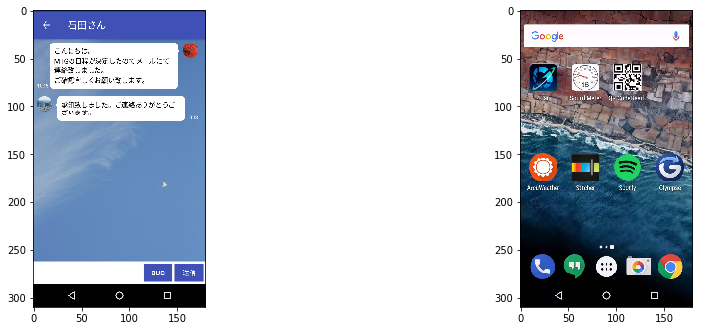

[[654 647 181 181]]
./base_img/Screenshot_20170620-194333.png : ./cat_img/9016.png : 0.2758605439845422
./base_img/Screenshot_20170620-194300.png : ./cat_img/9016.png : 1.5859106010880462
./base_img/Screenshot_20170620-194357.png : ./cat_img/9016.png : 2.2779179229493063
./base_img/Screenshot_20170620-194337.png : ./cat_img/9016.png : 0.2739820331179632
./base_img/Screenshot_20170620-194415.png : ./cat_img/9016.png : 0.5580953804566141
./base_img/Screenshot_20170620-194222.png : ./cat_img/9016.png : 0.27036114336894473
./base_img/Screenshot_20170620-194353.png : ./cat_img/9016.png : 1.586237299711368
./base_img/Screenshot_20170620-194311.png : ./cat_img/9016.png : 1.9341144370488448
./base_img/Screenshot_20170620-194306.png : ./cat_img/9016.png : 2.2775912243259846
./base_img/Screenshot_20170620-194215.png : ./cat_img/9016.png : 0.27256120552568935
./base_img/Screenshot_20170620-194231.png : ./cat_img/9016.png : 0.2738003268285124
./base_img/Screenshot_20170620-194348.png : ./cat_img/9

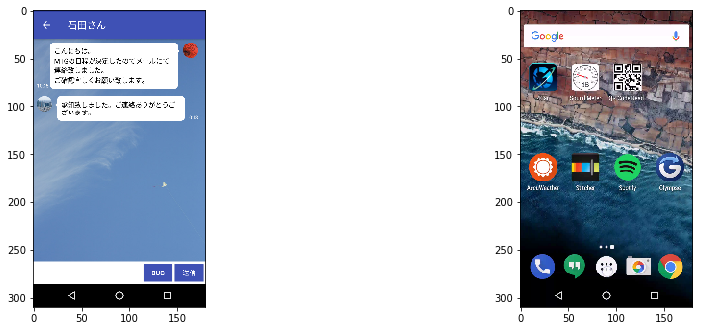

[[653 645 186 186]]
./base_img/Screenshot_20170620-194333.png : ./cat_img/9018.png : 0.049257703040558265
./base_img/Screenshot_20170620-194300.png : ./cat_img/9018.png : 0.024732970226681333
./base_img/Screenshot_20170620-194357.png : ./cat_img/9018.png : 0.11101394719138147
./base_img/Screenshot_20170620-194337.png : ./cat_img/9018.png : 0.0494597736709778
./base_img/Screenshot_20170620-194415.png : ./cat_img/9018.png : 0.3432208952367706
./base_img/Screenshot_20170620-194222.png : ./cat_img/9018.png : 0.043747142445506065
./base_img/Screenshot_20170620-194353.png : ./cat_img/9018.png : 0.02858873836302117
./base_img/Screenshot_20170620-194311.png : ./cat_img/9018.png : 0.04614630434133657
./base_img/Screenshot_20170620-194306.png : ./cat_img/9018.png : 0.10715817905504163
./base_img/Screenshot_20170620-194215.png : ./cat_img/9018.png : 0.03518163171355321
./base_img/Screenshot_20170620-194231.png : ./cat_img/9018.png : 0.04789433249360907
./base_img/Screenshot_20170620-194348.png : 

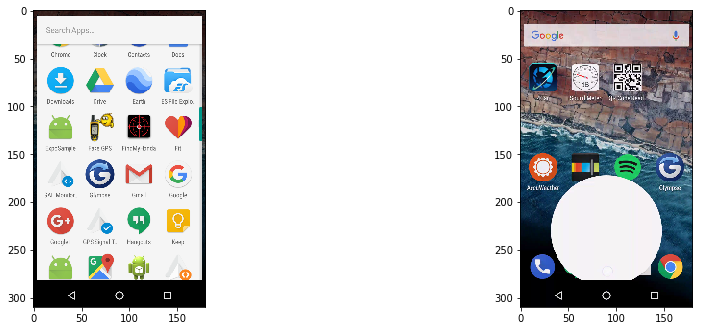

[[ 11  64 175 175]]
./base_img/Screenshot_20170620-194333.png : ./cat_img/9903.png : 0.1713056341018053
./base_img/Screenshot_20170620-194300.png : ./cat_img/9903.png : 0.4302578727262467
./base_img/Screenshot_20170620-194357.png : ./cat_img/9903.png : 0.36234154986149975
./base_img/Screenshot_20170620-194337.png : ./cat_img/9903.png : 0.17128714516040436
./base_img/Screenshot_20170620-194415.png : ./cat_img/9903.png : 0.09040665284283422
./base_img/Screenshot_20170620-194222.png : ./cat_img/9903.png : 0.10945034294287127
./base_img/Screenshot_20170620-194353.png : ./cat_img/9903.png : 0.43135300896373824
./base_img/Screenshot_20170620-194311.png : ./cat_img/9903.png : 0.3953436041474837
./base_img/Screenshot_20170620-194306.png : ./cat_img/9903.png : 0.3612464136240082
./base_img/Screenshot_20170620-194215.png : ./cat_img/9903.png : 0.17415952849837285
./base_img/Screenshot_20170620-194231.png : ./cat_img/9903.png : 0.17164602114270555
./base_img/Screenshot_20170620-194348.png : ./cat

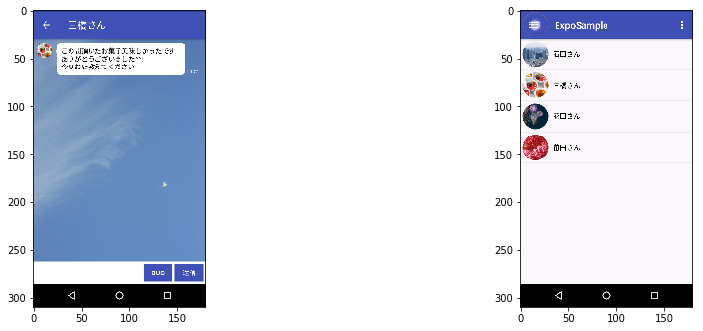

In [ ]:
# テストベースシナリオ
if __name__ == '__main__':
    va=VideoAnalyze('./2.mp4')
    senario_dict=va.main()
    print(senario_dict)
    f = open('{0}.json'.format("base_senario"), 'w')
    json.dump(senario_dict, f)
    f.close()